## Yield Spread Model


We try to use the transformer to predict the yield spread for the next trade, given information such as the price, yield spread etc about recent trades. 

The implementation was derived from the keras tutorial on [transformers](https://keras.io/examples/structured_data/movielens_recommendations_transformers/) and the transformer [tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) from pytorch.  I also referenced this [blog](https://jalammar.github.io/illustrated-transformer/) post on transformers

In [1]:
import pandas as pd
import numpy as np

from google.cloud import bigquery
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers

import plotly.graph_objects as go
from IPython.display import display, HTML

Setting the seed for keras layer initializer

In [2]:
layer_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=10)

Initializing big query client

In [3]:
bq_client = bigquery.Client()

### Checking if GPU is available

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

#### Hyper-parameters for the model
The batch size and learning rate have an impact on the smoothness of convergence of the model.\
Larger the batch size the smoother the convergence. For a larger batch size we need a higher learning rate and vice-versa

In [5]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.001
NUM_EPOCHS = 1000
SEQUENCE_LENGTH = 32
NUM_FEATURES= 5
STEP_SIZE = 1
HIDDEN_LAYERS = [400, 200, 50, 25]
DROPOUT_RATE = 0.01
NUM_HEADS = 4
BATCH_SIZE = 1000
TIME2VEC_DIMENSION = 10

We can either chose to use a Transformer or an LSTM to learn the features of the sequence. If we decide to use a transformer, we need to define the type of positional encoding which is fed to the attention layer. The current implementation offers a choice between sinusoidal encodings and time2vec. To use sinusoidal encodings set ENCODING_TYPE to 'positional', and to use tim2vec set it to 'time'

In [6]:
# Model type either Transformer or LSTM
# Setting this parameter will decide which architecture we use for
# the prediction of yield spreads
MODEL_TYPE = "Transformer"
ENCODING_TYPE = "Time"

#### Query to fetch data from BigQuery

We are using a part of the query from the [point in time query](https://docs.google.com/document/d/1pUkgovAG_og3oV6G7zF2d9ORq7t-eHJwEXHKKOU6E2k/edit?ts=60942e17) document. We are using the class to process the data msrb_transform view to create an aggregated table. We only use the trades which happened between 01/01/2021 and 04/01/2021 (later date not included)


In [7]:
DATA_QUERY = """ SELECT
  --Combination of rtrs_control_number and publish_datetime uniquely identifies the trade messages
  --and therefore we are groupping transaction messages based on these two fields
  --Note: there are few records that have same rtrs_control_number and publish_datetime, but different sequence_number and transaction_type that need to be explored later (e.g. 2020120307600500, 2021020407278700, 2020111902310500, 2021020201831300)
  latest.rtrs_control_number,
  latest.publish_datetime,
  --Previous transactions
  ARRAY_AGG(STRUCT (past.rtrs_control_number,
      past.cusip,
      past.trade_datetime,
      past.publish_datetime,
      past.msrb_valid_from_date,
      past.msrb_valid_to_date,
      past.yield_spread,
      past.yield,
      past.dollar_price,
      past.par_traded,
      past.trade_type,
      DATE_DIFF(latest.trade_date,past.trade_date, day) AS days_ago )
  ORDER BY
    past.trade_datetime ASC ) AS recent
FROM
  eng-reactor-287421.MSRB.msrb_transforms latest
LEFT JOIN
  eng-reactor-287421.MSRB.msrb_transforms past
ON
  latest.cusip = past.cusip
  AND latest.trade_datetime BETWEEN past.msrb_valid_from_date
  AND past.msrb_valid_to_date
WHERE
  --filter to show the most recent message for each trade
  latest.MSRB_INST_ORDR_DESC = 1
  --This date can be updated show all trades that has accored during the desired dates
  AND past.trade_date >= '2021-01-01'
  AND past.trade_date < '2021-04-01'
GROUP BY
  latest.rtrs_control_number,
  latest.publish_datetime
LIMIT
  10000
        """

### DataLoader Class

The DataLoader class grabs the data from BigQuery and returns the dataset as a dataframe. The query creates an array of all trades for every CUSIP. The query drops the trades that have been canceled. The yield spreads are already calculates in the msrb_tranforms view, by taking the diffrence of the bond's yield and the yield of the [s&p muni bond index](https://www.spglobal.com/spdji/en/indices/fixed-income/sp-municipal-bond-index/#overview). To test the implementation I have limited the number of rows to 10000, this can easily be changed by removing the limit in the DATA_QUERY.

The main driver method of the class is the processData function, which has been implemented as a class method. I decided to implement it as a class method as it can be easily called in other files without creating an instance for the class

The dataset is split into training and testing, with 85% of the data being used to train the model. The parameter that decides the ratio of train test split is defined in the cells above. We create a sequence of 5 trades and feed that into the model. The sequence parameter is defined as a hyper-parameter and can be easily changed. The sequence contains the yield spreads, prices, par traded value, the type of trade, and the number of days ago the trade was executed. Additional features can be added with a few minor tweaks to the source code.  

I do a few blunt normalizations to help the model learn. I multiply the yield spreads by 100 to convert the units to basis points and divide the par trade value by 1000 to reduce the absolute scale. We can try other normalization schemes to see how that affects the learning of the model


In [9]:
class DataLoader(object):
    '''
    Class to load the data from big query 
    and process it to create train and test data
     '''
    def __init__(self,query,client):
        self.query = query
        self.trade_dataframe = None
        self.client = client
        
    @staticmethod
    def createSequence(x):
        '''
        Creates sequence of historical trades
        x : list
        
        This function uses list slicing to create the desired sequence of trades
        If the CUSIP does not have enough trades, we drop it. 
        
        At each iteration, the counter(base) is increased by STEP_SIZE and then the function
        extracts SEQUENCE_LENGTH size chunk of trades to create the sequence.
        
        '''
        chunks = [x[base:base+SEQUENCE_LENGTH]\
                  for base in range(0,len(x), STEP_SIZE)\
                  if len(x[base:base+SEQUENCE_LENGTH]) == SEQUENCE_LENGTH]
        return chunks

    @staticmethod
    def tradeDictToList(trade_dict: dict) -> list:
        '''
        This function converts the recent trades dictionary
        to a list. The SQL array is converted to a dictionary
        when read as a pandas dataframe

        parameters:
        trade_dict : dict
        '''
        trade_type_mapping = {'D':[0,0],'S': [0,1],'P': [1,0]}

        # A few blunt normalizations will experiment with others as well
        # Multiplying the yield spreads by 100 to convert to basis points
        # Dividing the trade value by 1000 to reduce the absolute scale 

        trade_list = []
        trade_list.append(trade_dict['yield_spread'] * 100)
        trade_list.append(np.float32(trade_dict['par_traded']/1000))        
        trade_list += trade_type_mapping[trade_dict['trade_type']]
        trade_list.append(trade_dict['days_ago'] + trade_dict['trade_datetime'].hour /24)
        
        return np.stack(trade_list)
    
    @staticmethod
    def tradeListToArray(trade_history):
        '''
        parameters:
        trade_history - list
        
        This function creates the trade history array
        '''
        if len(trade_history) == 0:
            return np.array([])
        
        trades_list = [DataLoader.tradeDictToList(entry) for entry in trade_history]
        return np.stack(trades_list)

    
    @staticmethod
    def create_features(x):
        '''
        Returns the SEQUENCE_LENGTH - 1
        elements of the trade history array
        '''
        try:
            return x[:SEQUENCE_LENGTH - 1]
        except Exception as e:
            # debugging code
            print(x)
            raise e

    @staticmethod
    def create_target(x):
        try:
            return x[SEQUENCE_LENGTH-1][0]
        except Exception as e:
            # debugging code
            print(x)
            raise e
        
    def fetchData(self):
        '''
        Function executes the query to fetch data from BigQuery
        and apply helper functions to create the trade history array
        '''               
        if os.path.isfile('transformer.pkl'):
            self.trade_dataframe = pd.read_pickle('transformer.pkl')
        else:
            self.trade_dataframe = self.client.query(self.query).result().to_dataframe()
            
        self.trade_dataframe['trade_history'] = self.trade_dataframe.recent.apply(self.tradeListToArray)
        self.trade_dataframe.drop(columns=['recent'],inplace=True)
        
    # Class functions do not need an instance of the class to be called.
    # They are methods associated with the class and not the instance
    # and can be called by the class directly
    @classmethod
    def processData(cls,query,client):
        '''
        Class method to process data from bigquery to create
        the train and test set
        '''
        instance = cls(query,client)
        instance.fetchData()
        instance.trade_dataframe.trade_history = instance.trade_dataframe.trade_history.apply(instance.createSequence) 
        
        instance.trade_dataframe = instance.trade_dataframe[['rtrs_control_number','trade_history']].explode("trade_history",ignore_index=True)
        instance.trade_dataframe = instance.trade_dataframe.dropna()
        
        instance.trade_dataframe['features'] = instance.trade_dataframe['trade_history'].apply(instance.create_features)
        instance.trade_dataframe['target'] = instance.trade_dataframe['trade_history'].apply(instance.create_target)
        instance.trade_dataframe = instance.trade_dataframe.drop(columns=['trade_history'])
        
        np.random.seed(10)
        random_selection = np.random.rand(len(instance.trade_dataframe.index)) <= TRAIN_TEST_SPLIT
        print(f"Number of training Samples {len(instance.trade_dataframe[random_selection])}"")
        train_data = instance.trade_dataframe[random_selection]
        test_data = instance.trade_dataframe[~random_selection]
        display(train_data.head())
        return train_data,test_data
    
    

In [10]:
# if os.path.isfile('test.pkl') and os.path.isfile('train.pkl'):
#     train_dataframe = pd.read_pickle('train.pkl')
#     test_dataframe = pd.read_pickle('test.pkl')
# else:
train_dataframe, test_dataframe = DataLoader.processData(DATA_QUERY,bq_client)

Number of training Samples 67551


,rtrs_control_number,features,target
0,2021031700698100,"[[5.997612444822997, 50.0, 0.0, 0.0, 71.458333...",20.281352
1,2021031700698100,"[[5.997612444822997, 50.0, 0.0, 0.0, 71.458333...",19.181352
2,2021031700698100,"[[6.997612444822998, 50.0, 1.0, 0.0, 71.458333...",21.596133
3,2021031700698100,"[[-5.702387555177002, 50.0, 0.0, 1.0, 71.45833...",17.063724
4,2021031700698100,"[[10.397612444823, 5.0, 0.0, 0.0, 71.458333333...",17.063724


In [12]:
# Shuffling the train set
train_dataframe = train_dataframe.sample(frac=1)
display(train_dataframe)

,rtrs_control_number,features,target
11522,2021031103862600,"[[220.76321754735204, 10.0, 1.0, 0.0, 22.54166...",213.000103
47944,2021020306474200,"[[102.93366562780201, 200.0, 0.0, 0.0, 5.45833...",94.781352
40120,2021030905498300,"[[86.75315316115302, 100.0, 0.0, 1.0, 11.41666...",82.653759
1659,2021050403881500,"[[-28.502387555177002, 10.0, 1.0, 0.0, 119.541...",-49.564339
70771,2021040601117700,"[[16.511145083328003, 250.0, 0.0, 1.0, 40.4583...",46.153153
...,...,...,...
73972,2021012906555300,"[[1.8763078263379862, 25.0, 1.0, 0.0, 23.54166...",-57.566334
5454,2021032405703300,"[[353.00961685947004, 20.0, 1.0, 0.0, 56.66666...",293.011145
50460,2021040802569400,"[[381.14914707290404, 1.0, 0.0, 1.0, 34.583333...",386.235661
38672,2021033102771400,"[[151.676307826338, 50.0, 1.0, 0.0, 84.5416666...",136.324759


Changing the dataframe to numpy array so that data can be fed into the input layer of the model

In [13]:
train_data = np.stack(train_dataframe.features.to_numpy())
target = train_dataframe.target.to_numpy()

test_data = np.stack(test_dataframe.features.to_numpy())
test_target =  test_dataframe.target.to_numpy()

In [16]:
print(train_data.shape)
print(target.shape)
print(test_data.shape)

(67551, 31, 5)
(67551,)
(11737, 31, 5)


## Time2Vec layer
The following class creates a custom [time2vec](https://arxiv.org/pdf/1907.05321.pdf) layer. Time2vec is a learnable vector representation of time. It is defined as follows

<center>
 $\text{T2V}(\tau)_{[i]} =
\left\{
	\begin{array}{ll}
		 \omega_i \tau + \phi_i  & \mbox{if } i = 0 \\
		 \mathscr{F}(\omega_i \tau + \phi_i) & \mbox{if } 1 \leq i \leq k 
	\end{array}
\right.
$
    
Where T2V($\tau$)[i] is the $i^{th}$ element of T2V($\tau$), $\mathscr{F}$ is a periodic activation function, and $\omega_i$ and $\phi_i$  are
learnable parameters. K in the above equation is the kernel size and it represents the size of the final vector. The word kernel defines the set of weights that transform the input into the required vector representation The kernel size is defined as a hyper-parameter in the second cell in the notebook

    
The implementation of the class was derived from the keras custom layer [tutorial](https://keras.io/guides/making_new_layers_and_models_via_subclassing/).

In [142]:
class Time2Vec(layers.Layer):
    '''
        Implementation of the Time2Vec layer
    '''
    def __init__(self, kernel_size):
        '''
        The kernel size is the length of the time vector
        '''
        super(Time2Vec, self).__init__(trainable=True)
        self.kernel_size = kernel_size
    
    def build(self, input_shape):
        '''
        Declaring the weights and biases for the layer.
        This function is called by the call function
        only the first time. This logic is handled by the
        keras Layer class
        '''
        # initial representation
        self.wb = self.add_weight(
            shape=(1, 1),
            initializer='uniform',
            trainable=True
        )
        
        self.bb = self.add_weight(
            shape=(1, 1),
            initializer='uniform',
            trainable=True
        )
        
        # Periodic activation
        self.w = self.add_weight(
            shape=(1, self.kernel_size),
            initializer='uniform',
            trainable=True
        )
        
        self.b = self.add_weight(
            shape=(1, self.kernel_size),
            initializer='uniform',
            trainable=True
        )
        
        super(Time2Vec, self).build(input_shape)
    
    def call(self, inputs, **kwargs):
        '''
        The call function calls the build function to initialize the weights and biases, once they are
        initialized the function then performs the necessary operations. 
        :inputs: A Tensor with shape (batch_size, feature_size, 1)
        :return: A Tensor with shape (batch_size, feature_size, length of time vector representation + 1)
        '''
        bias = self.wb * inputs + self.bb
        wgts = K.sin(K.dot(inputs, self.w) + self.b)
        return K.concatenate([bias, wgts], -1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.k + 1)


# Transformer Model

The model is made up of a multi-headed attention layer, with a feed-forward neural network stacked on top of it. 

The input features (yield spreads, price, trade type, par trade value, and days from previous trade) are combined with positional encodings. I used positional encodings as described in the '[Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf)' paper. The embeddings are created as follows. 

<center>
 $\large p_t =
\left\{
	\begin{array}{ll}
		 \sin(\omega_it )  & \mbox{if } i = 2k \\
		 \cos(\omega_it) & \mbox{if } i = 2k +1 
	\end{array}
\right.
$

</center>

Where $\omega$ is defined as follows
<center>
$
\Large \omega_i = \frac{1}{1000 ^ \frac{2i}{d}} \hspace{1cm} \small 0 \leq i \leq d
$

</center>

Here t is the position in the input sequence, and d is the dimension of the encoding. The positional encodings are then added to the input features, before being fed to the multi-headed attention layer.



In [143]:
class YieldSpreadModel(object):
    '''
    Class to create the transformer model
    '''
    
    @staticmethod
    def model_input():
        '''
        Creates a dictionary of all the 
        inputs to the model
        '''
        return {
            "features" : layers.Input(name="yield_sequence", shape=((SEQUENCE_LENGTH - 1),NUM_FEATURES), dtype = tf.float32)
        }

        
    @staticmethod
    def input_features(inputs,MODEL_TYPE,ENCODING_TYPE):
        input_features = inputs['features']
        
        if MODEL_TYPE.upper() == "TRANSFORMER":
            if ENCODING_TYPE.upper() == "POSITIONAL":
                positional_encodings = np.array([ [pos/np.power(1000,2*i/NUM_FEATURES) \
                                                   for i in range(NUM_FEATURES)]\
                                                   for pos in range(SEQUENCE_LENGTH-1)])
                positional_encodings[1:, 0::2] = np.sin(positional_encodings[1:, 0::2])
                positional_encodings[1:, 1::2] = np.cos(positional_encodings[1:, 1::2])
                positional_encodings = tf.convert_to_tensor(positional_encodings, dtype=tf.float32)
                positional_encodings = positional_encodings[None,:,:]
                input_features = input_features + positional_encodings
            
            elif ENCODING_TYPE.upper() == "TIME":
                time_features = input_features[:,:,-1]
                time_features = tf.reshape(time_features,[-1,SEQUENCE_LENGTH-1,1])
                time_features = Time2Vec(TIME2VEC_DIMENSION)(time_features)
                input_features = input_features[:,:,:-1]
                input_features = layers.concatenate([input_features,time_features], axis=2)
            else:
                raise NotImplementedError('Neither positional or time encoding selected.')
            
        return input_features
        
    @classmethod
    def create_model(cls,MODEL_TYPE='TRANSFORMER',ENCODING_TYPE='Positional'):
        '''
        Returns the model to predict the yield spreads
        Depending on the MODEL_TYPE the model can either use
        Transformer or an LSTM to extract information from the sequence
        '''
        
        instance = cls()
        inputs = instance.model_input()
        
        
        if MODEL_TYPE.upper() == 'TRANSFORMER':
            transformer_features = instance.input_features(inputs,MODEL_TYPE,ENCODING_TYPE)
            # Attention layer
            # Key and values are same for self attention
            attention_output = layers.MultiHeadAttention(num_heads=NUM_HEADS,
                                                         kernel_initializer = layer_initializer,
                                                         key_dim=transformer_features.shape[2])(transformer_features, transformer_features)

            # Transformer block.
            attention_output = layers.Dropout(DROPOUT_RATE)(attention_output)
            x1 = layers.Add()([transformer_features, attention_output])
            x1 = layers.LayerNormalization()(x1)
            x2 = layers.LeakyReLU()(x1)
            x2 = layers.Dense(units=x2.shape[-1],kernel_initializer=layer_initializer)(x2)
            x2 = layers.Dropout(DROPOUT_RATE)(x2)
            transformer_features = layers.Add()([x1, x2])
            transformer_features = layers.LayerNormalization()(transformer_features)
            features = layers.Flatten()(transformer_features)
        
        elif MODEL_TYPE.upper() == 'LSTM':
            lstm_features = instance.input_features(inputs)
            lstm_layer = layers.LSTM(20, 
                                   activation='tanh',
                                   input_shape=(SEQUENCE_LENGTH,NUM_FEATURES))
            features = lstm_layer(lstm_features)
        
        # The loops is used to create the feed-froward NN
        for LAYER in HIDDEN_LAYERS:
            features = layers.Dense(LAYER, kernel_initializer=layer_initializer)(features)
            features = layers.BatchNormalization()(features)
            features = layers.Activation(activations.tanh)(features)
            #features = layers.Dropout(DROPOUT_RATE)(features)

        outputs = layers.Dense(units=1)(features)
        model = keras.Model(inputs=inputs, outputs=outputs)
        
        return model
    

In [144]:
model = YieldSpreadModel.create_model(MODEL_TYPE,"Time")

In [145]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
yield_sequence (InputLayer)     [(None, 31, 5)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_20 (Sl (None, 31)           0           yield_sequence[0][0]             
__________________________________________________________________________________________________
tf.reshape_10 (TFOpLambda)      (None, 31, 1)        0           tf.__operators__.getitem_20[0][0]
__________________________________________________________________________________________________
tf.__operators__.getitem_21 (Sl (None, 31, 4)        0           yield_sequence[0][0]             
___________________________________________________________________________________________

In [146]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [147]:
%time history = model.fit(train_data, target, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,  verbose=2, validation_split=0.2)

Epoch 1/1000
55/55 - 3s - loss: 63168.7109 - mean_absolute_error: 159.7690 - val_loss: 59143.1641 - val_mean_absolute_error: 156.8277
Epoch 2/1000
55/55 - 1s - loss: 62637.4922 - mean_absolute_error: 158.2638 - val_loss: 58575.6641 - val_mean_absolute_error: 155.2406
Epoch 3/1000
55/55 - 1s - loss: 62150.1172 - mean_absolute_error: 156.9498 - val_loss: 58110.0703 - val_mean_absolute_error: 153.8829
Epoch 4/1000
55/55 - 1s - loss: 61659.2773 - mean_absolute_error: 155.5734 - val_loss: 57833.6094 - val_mean_absolute_error: 153.5831
Epoch 5/1000
55/55 - 1s - loss: 61153.3008 - mean_absolute_error: 154.1013 - val_loss: 57368.1953 - val_mean_absolute_error: 152.0145
Epoch 6/1000
55/55 - 1s - loss: 60651.3242 - mean_absolute_error: 152.6320 - val_loss: 56811.8086 - val_mean_absolute_error: 150.1325
Epoch 7/1000
55/55 - 1s - loss: 60148.7578 - mean_absolute_error: 150.9761 - val_loss: 56492.7344 - val_mean_absolute_error: 149.1694
Epoch 8/1000
55/55 - 1s - loss: 59653.9336 - mean_absolute_err

In [148]:
_, mae = model.evaluate(test_data, test_target, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

367/367 [==============================] - 1s 2ms/step - loss: 12771.0049 - mean_absolute_error: 13.5966
Test MAE: 13.597


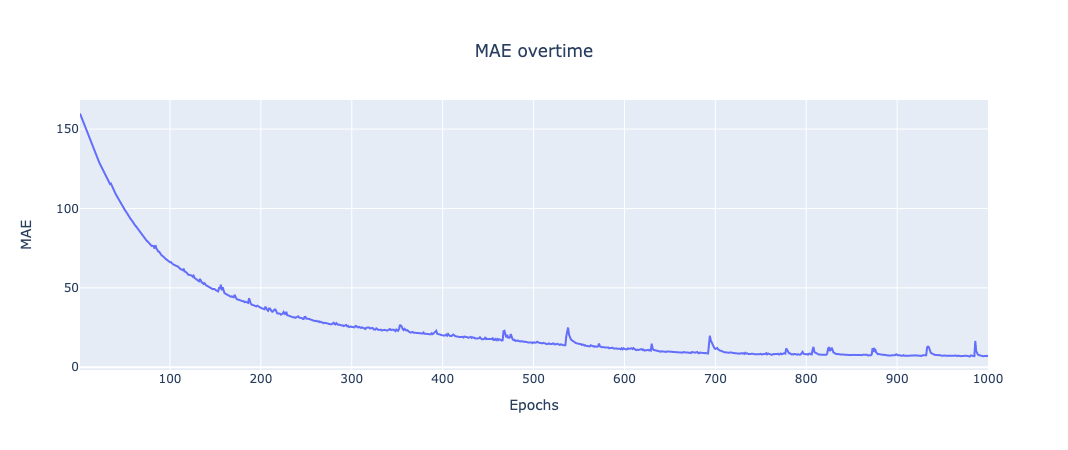

In [149]:
fig = go.Figure(data=go.Scatter(x=list(range(1,len(history.history['mean_absolute_error'])+1)), y = history.history['mean_absolute_error']))
fig.update_layout(title={'text':"MAE overtime", 'y':0.9, 'x':0.5, 'xanchor': 'center','yanchor': 'top'}, xaxis_title="Epochs", yaxis_title="MAE")
fig.show()